# Info 

Author: Xiaoqian Sun <br>
Created: 08/2023 <br>
Function: Apply Oasis on dff to infer spikes and compare that result with the inference using peeling algorithm.


In [21]:
import os 
import cv2
import time
import math
import h5py
import random
import pickle
import imageio
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Functions import *
from simuParams import simuParams
from simulation import Simulation
from peelParams import peelParams
from peelReconstruction import peelReconstr

import warnings
warnings.filterwarnings('ignore')

In [22]:
# file path
root_path = os.getcwd()
data_path = os.path.join(root_path, 'Poisson_CaImAnTest')

# parameters
dur = 10
cellNum = 10
frameRate = 30
dims = (512, 512)
samplingRate = 600

fileName = 'OASIS'

# Load Simulation&Peel Obj

In [96]:
with open(os.path.join(data_path,'simulation_Object.pkl'), 'rb') as fp:
    simuObj = pickle.load(fp)
    print('simuObj  loaded')

    
# dump
with open(os.path.join(data_path,'peel_Object.pkl'), 'rb') as fp:
    peelObj_dic = pickle.load(fp)
    print('peel_Object  saved')

simuObj  loaded
peel_Object  saved


In [40]:
# simulated dff
# peeling algorithm is also applied on dff
dff = pd.DataFrame(simuObj.sampledFluor).T
F = pd.DataFrame(simuObj.noisyFluor).T
print(dff.shape, F.shape)
dff.head(2)

(300, 10) (6000, 10)


,0,1,2,3,4,5,6,7,8,9
0,1.264206,0.256697,0.183468,-1.911968,0.771239,7.836462,2.128451,3.235281,11.117869,4.683591
1,1.518710,0.560035,-0.807278,0.889162,0.210293,6.419345,-0.186924,1.746529,14.591582,10.884729


# OASIS Deconvolution & Spikes On DFF


In [51]:
# OASIS - by calling function
df_D, df_S = deconvolve_df(dff, ifSave=False)

df_D.to_csv(os.path.join(data_path, fileName+"-D.csv")) # denoise dff
df_S.to_csv(os.path.join(data_path, fileName+"-S.csv")) # denoise dff


### Plot 

In [73]:
# plot OASIS result
plot_neuronTrace_DFs([dff, df_D, df_S],['GT DFF', 'OASIS deconvol', 'OASIS Spike'],
                     ['grey', 'g', 'r'],[0.4, 1, 0.6],[4, 2, 1],
                     ifSave=True, savePath=data_path, filename=fileName+'_DFF')

### GrountTruth, OASIS Comparison

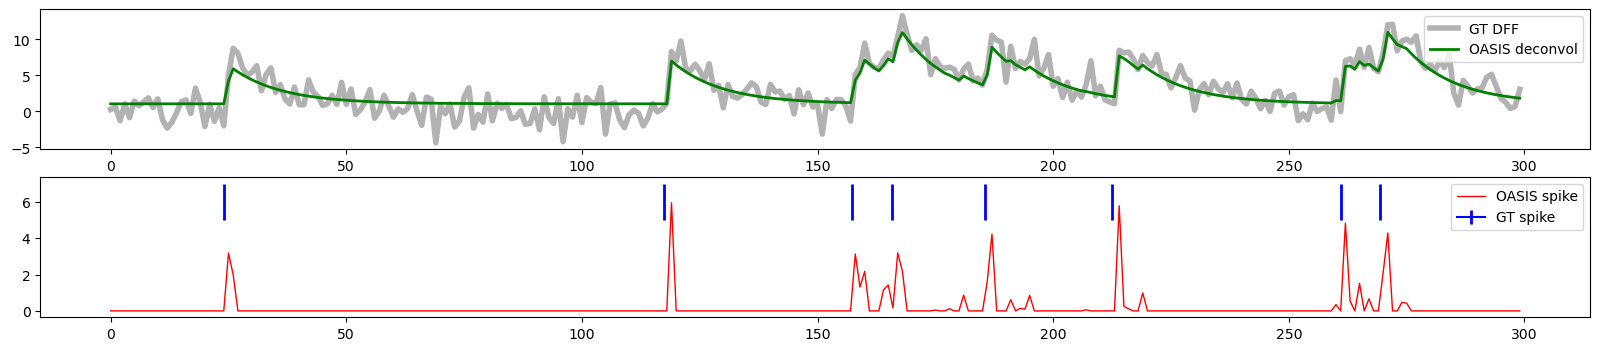

In [79]:
# Compare 
neuronIndex = 1
sMax = math.ceil(df_S.iloc[:, neuronIndex].max().max())
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,2*2),facecolor='w', edgecolor='k')

# OASIS deconvolution
ax1.plot(dff.iloc[:, neuronIndex], color='grey', lw=4, alpha=0.6, label='GT DFF')
ax1.plot(df_D.iloc[:, neuronIndex], color='g', lw=2, alpha=1, label='OASIS deconvol')
ax1.legend(loc=1)


# OASIS spikes
ax2.plot(df_S.iloc[:, neuronIndex], color='r', lw=1, alpha=1, label='OASIS spike')
ax2.legend(loc=1)
spkTimes = simuObj.params.simulation['spkTimes'][neuronIndex]
for n in range(len(spkTimes)):
    if n==0:
        ax2.errorbar(spkTimes[n]*frameRate, label='GT spike',y=sMax, yerr=1, c='blue', elinewidth=2)
        ax2.legend()
    else:
        ax2.errorbar(spkTimes[n]*frameRate, y=sMax, yerr=1, c='blue', elinewidth=2)

        
plt.show()

### GrountTruth, OASIS Zoom In

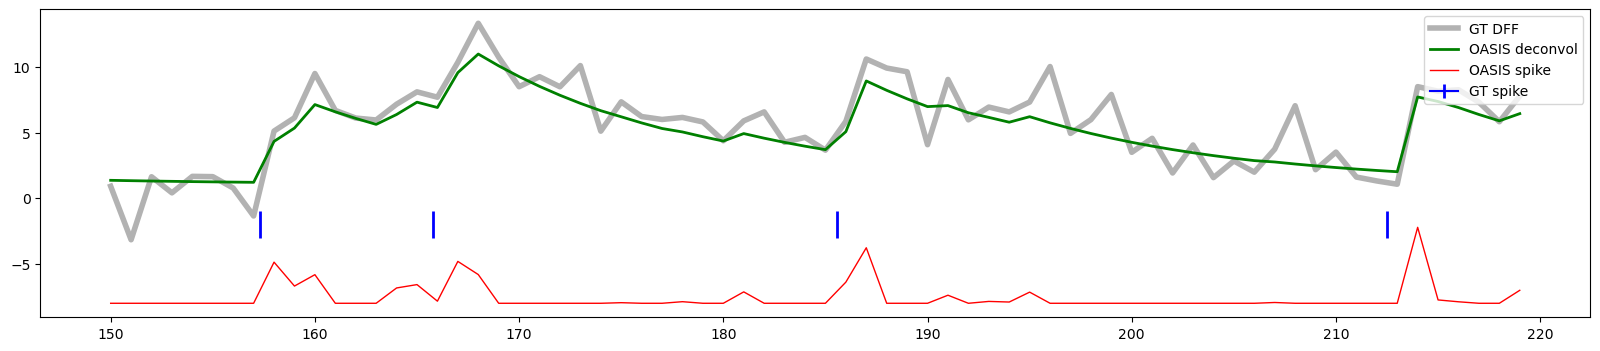

In [100]:
# Compare 
neuronIndex = 1
# sMax = math.ceil(df_S.iloc[:, neuronIndex].max().max())+10
sMax=-2
fig, ax = plt.subplots(figsize=(20,2*2),facecolor='w', edgecolor='k')

# OASIS deconvolution
ax.plot(dff.iloc[:, neuronIndex][150:220], color='grey', lw=4, alpha=0.6, label='GT DFF')
ax.plot(df_D.iloc[:, neuronIndex][150:220], color='g', lw=2, alpha=1, label='OASIS deconvol')

# OASIS spikes
ax.plot(df_S.iloc[:, neuronIndex][150:220]-8, color='r', lw=1, alpha=1, label='OASIS spike')
ax.legend(loc=1)
spkTimes = simuObj.params.simulation['spkTimes'][neuronIndex]
for n in range(2,6):
    if n==2:
        ax.errorbar(spkTimes[n]*frameRate, label='GT spike',y=sMax, yerr=1, c='blue', elinewidth=2)
        ax.legend()
    else:
        ax.errorbar(spkTimes[n]*frameRate, y=sMax, yerr=1, c='blue', elinewidth=2)

ax.legend(loc=1)        
plt.show()

### GrountTruth, OASIS, Peel Comparison

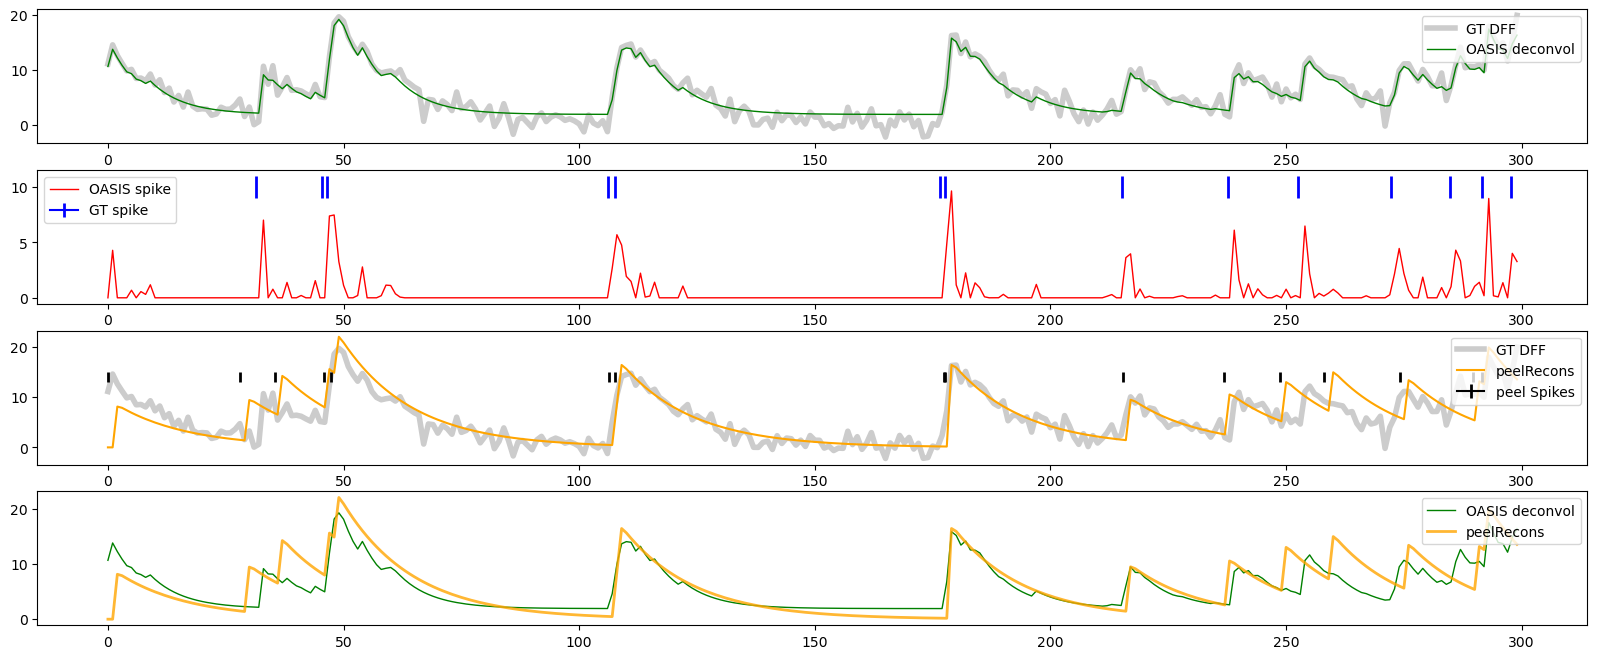

In [98]:
# Compare 
neuronIndex = 8
sMax = math.ceil(df_S.iloc[:, neuronIndex].max().max())
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(20,4*2),facecolor='w', edgecolor='k')

# OASIS deconvolution
ax1.plot(dff.iloc[:, neuronIndex], color='grey', lw=4, alpha=0.4, label='GT DFF')
ax1.plot(df_D.iloc[:, neuronIndex], color='g', lw=1, alpha=1, label='OASIS deconvol')
ax1.legend(loc=1)


# OASIS spikes
ax2.plot(df_S.iloc[:, neuronIndex], color='r', lw=1, alpha=1, label='OASIS spike')
ax2.legend(loc=1)
spkTimes = simuObj.params.simulation['spkTimes'][neuronIndex]
for n in range(len(spkTimes)):
    if n==0:
        ax2.errorbar(spkTimes[n]*frameRate, label='GT spike',y=sMax, yerr=1, c='blue', elinewidth=2)
        ax2.legend()
    else:
        ax2.errorbar(spkTimes[n]*frameRate, y=sMax, yerr=1, c='blue', elinewidth=2)

        
# peel reconstruction, spikes
peelObj = peelObj_dic['neuron'+str(neuronIndex)]
dffRecon = peelObj.dffRecon
spkTimesRecon = peelObj.spkTimesRecon
sMax = math.ceil(max(peel))

ax3.plot(dff.iloc[:, neuronIndex], color='grey', lw=4, alpha=0.4, label='GT DFF')
ax3.plot(dffRecon, c='orange', label='peelRecons')
for n in range(len(spkTimesRecon)):
    if n==0:
        ax3.errorbar(spkTimesRecon[n]*frameRate, label='peel Spikes',y=sMax, yerr=1, c='black', elinewidth=2)
        ax3.legend()
    else:
        ax3.errorbar(spkTimesRecon[n]*frameRate, y=sMax, yerr=1, c='black', elinewidth=2)
ax3.legend(loc=1)

ax4.plot(df_D.iloc[:, neuronIndex], color='g', lw=1, alpha=1, label='OASIS deconvol')        
ax4.plot(dffRecon, c='orange',lw=2,alpha=0.8, label='peelRecons')
ax4.legend(loc=1)

        
plt.show()